# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from tqdm import tqdm

In [ ]:
df = pd.read_csv('/autos.csv')
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0.0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0.0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0.0,90480.0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0.0,91074.0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0.0,60437.0,2016-04-06 10:17:21


*Признаки
DateCrawled — дата скачивания анкеты из базы
VehicleType — тип автомобильного кузова
RegistrationYear — год регистрации автомобиля
Gearbox — тип коробки передач
Power — мощность (л. с.)
Model — модель автомобиля
Kilometer — пробег (км)
RegistrationMonth — месяц регистрации автомобиля
FuelType — тип топлива
Brand — марка автомобиля
Repaired — была машина в ремонте или нет
DateCreated — дата создания анкеты
NumberOfPictures — количество фотографий автомобиля
PostalCode — почтовый индекс владельца анкеты (пользователя)
LastSeen — дата последней активности пользователя*

In [ ]:
df[['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen','DateCrawled']]

,NumberOfPictures,PostalCode,DateCrawled,LastSeen,DateCrawled
0,0.0,70435.0,2016-03-24 11:52:17,2016-04-07 03:16:57,2016-03-24 11:52:17
1,0.0,66954.0,2016-03-24 10:58:45,2016-04-07 01:46:50,2016-03-24 10:58:45
2,0.0,90480.0,2016-03-14 12:52:21,2016-04-05 12:47:46,2016-03-14 12:52:21
3,0.0,91074.0,2016-03-17 16:54:04,2016-03-17 17:40:17,2016-03-17 16:54:04
4,0.0,60437.0,2016-03-31 17:25:20,2016-04-06 10:17:21,2016-03-31 17:25:20
...,...,...,...,...,...
192666,0.0,80689.0,2016-03-14 13:52:10,2016-03-14 13:52:10,2016-03-14 13:52:10
192667,0.0,36208.0,2016-03-28 14:56:24,2016-04-04 17:18:28,2016-03-28 14:56:24
192668,0.0,58706.0,2016-03-23 23:52:36,2016-03-28 14:47:35,2016-03-23 23:52:36
192669,0.0,48351.0,2016-03-08 23:36:19,2016-04-03 03:49:50,2016-03-08 23:36:19


Удаляем столбцы которые не бедет учавствовать в анализе
DateCrawled — дата скачивания анкеты из базы
LastSeen — дата последней активности пользователя
DateCreated — дата создания анкеты
PostalCode — почтовый индекс владельца анкеты (пользователя)
NumberOfPictures — количество фотографий автомобиля.
Данные стобцы не несут важных данных для машинного обучения, дата публикации, индекс, и активности людей, не влияют на конечную стоимость авто. По данным даты не возможно восстановить прорущеные данные, а значит столбцы не требуются для дальнейшей работы

In [ ]:
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen','DateCrawled'], axis=1)

*Проверим дубликаты*

In [ ]:
df.duplicated().sum()


3563

Имеются дебликаты 11834 шт, удалим их

In [ ]:
df= df.drop_duplicates()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189108 entries, 0 to 192670
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              189108 non-null  int64 
 1   VehicleType        168894 non-null  object
 2   RegistrationYear   189108 non-null  int64 
 3   Gearbox            178590 non-null  object
 4   Power              189108 non-null  int64 
 5   Model              178425 non-null  object
 6   Kilometer          189108 non-null  int64 
 7   RegistrationMonth  189108 non-null  int64 
 8   FuelType           171270 non-null  object
 9   Brand              189108 non-null  object
 10  Repaired           150800 non-null  object
 11  DateCreated        189108 non-null  object
dtypes: int64(5), object(7)
memory usage: 18.8+ MB


In [ ]:
df.isna().sum()

Price                    0
VehicleType          20214
RegistrationYear         0
Gearbox              10518
Power                    0
Model                10683
Kilometer                0
RegistrationMonth        0
FuelType             17838
Brand                    0
Repaired             38308
DateCreated              0
dtype: int64

Имеются пропуски в данных:
VehicleType          37490 тип автомобильного кузова
Gearbox              19833 тип коробки передач
Model                19705 модель автомобиля
FuelType             32895 тип топлива
Repaired             71154 была машина в ремонте или нет

Далее займемся очисткой данных от пропусков


Заменим пропуски в столбце тип кузова модой. Половину значений заменяю через группировку, остаток уже без группировки. Если
удалять значения получится слишком большой процент потери исходных данных

In [ ]:
df['VehicleType'] = df.groupby('Model')['RegistrationYear'].apply(lambda x: x.fillna(x.mode()[0]))
df["VehicleType"] = df["VehicleType"].fillna(df["VehicleType"].mode().values[0])
df["VehicleType"].isna().sum()

<ipython-input-14-89c2b65fcb95>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['VehicleType'] = df.groupby('Model')['RegistrationYear'].apply(lambda x: x.fillna(x.mode()[0]))


0

В колонке информация о ремонте заполняем пропуски на unknown. Предполлогаю что либо пропуск возникает по причине того что авто
не было в ремонте(бито), либо такую информацию просто не указали в объявление, либо в случае если информация подтягивается
из баз ГАИ автоматически, она отсутствует. Более логично проставить вместо пропусков unknown

In [ ]:

df['Repaired'] = df['Repaired'].fillna('unknown')
df['Repaired'].isna().sum()

0

Заменим пропуски в столбце тип топлива модой

In [ ]:

df['FuelType'] = df['FuelType'].fillna(df['FuelType'].mode().values[0])
df['FuelType'].isna().sum()

0

Заменим пропуски в столбце тип коробки передач модой

In [ ]:
df['Gearbox'] = df['Gearbox'].fillna(df['Gearbox'].mode().values[0])
df['Gearbox'].isna().sum()

0

Пропуски в столбце модель авто заменяем на заглушку unknown

In [ ]:

df['Model'] = df['Model'].fillna('unknown')

df['Model'].isna().sum()

0

*Проверяем данные на аномалии*

In [ ]:
df.describe()

,Price,VehicleType,RegistrationYear,Power,Kilometer,RegistrationMonth
count,189108.000000,189108.000000,189108.000000,189108.000000,189108.000000,189108.000000
mean,4421.289501,2003.682303,2004.233401,110.037217,128173.583349,5.699521
std,4529.192094,67.478609,91.603040,190.246600,37901.296732,3.727700
min,0.000000,1000.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1001.000000,1999.000000,1999.000000,68.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2007.000000,2008.000000,141.000000,150000.000000,9.000000
max,20000.000000,9999.000000,9999.000000,19211.000000,150000.000000,12.000000


Text(0.5, 1.0, 'Гистограмма года выпуска авто')

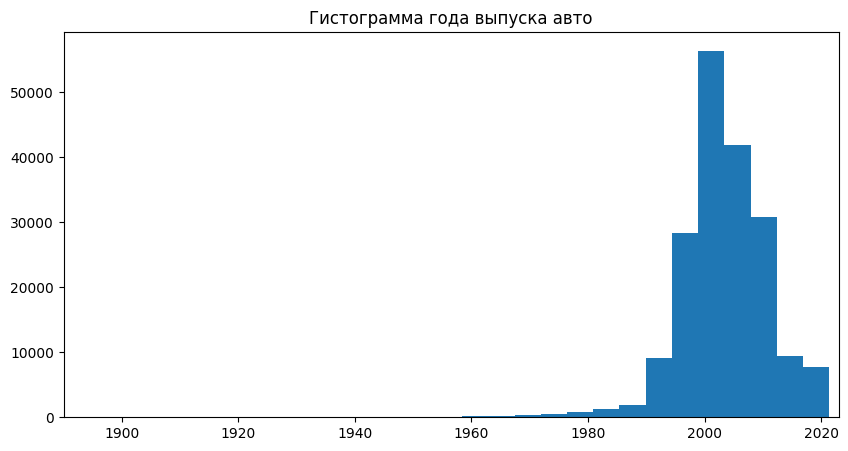

In [ ]:

plt.figure(figsize=[10,5])

plt.hist(df['RegistrationYear'],bins=2000)
plt.xlim([1890, 2023])
plt.title('Гистограмма года выпуска авто')


При взгляде на гистограмму год  выпуска видим аномалии, соответсвенно задаем актуальные значения периода. Нижняя граница после 1980 года.
Верхняя до 2016(год регисрации анкет, машины не могут быть позже данного года выпуска)

In [ ]:
df = df.loc[(df['RegistrationYear']>1980) &(df['RegistrationYear']<=2016)]

Text(0.5, 1.0, 'Гистограмма мощности авто')

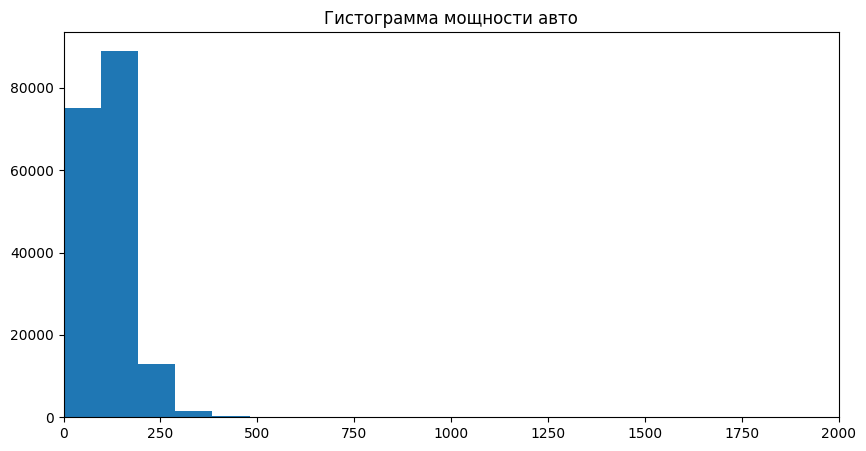

In [ ]:
plt.figure(figsize=[10,5])

plt.hist(df['Power'],bins=200)
plt.xlim([0, 2000])
plt.title('Гистограмма мощности авто')



При взгляде на данные видны аномалии, есть значения выше 1000 л.с. При этом в списке нет моделей машин, которые могут иметь
такую мощность, например тягочи, спортивные машины и т.д. Делаем вывод что такая аномалия взялась из за лишнего нуля.
Данные необходимо преобразовать поделив значение выше 1000 л.с на 10. И в работу берем значения больше 0 л.с

In [ ]:

df.loc[df['Power'] > 1000, 'Power'] = df.loc[df['Power'] > 1000, 'Power'] / 10
df = df.loc[df['Power']>0]

In [ ]:
#Убираем нулевые значения цены авто
df['Price'].value_counts()

0        3383
500      2378
1500     2333
1200     1950
2500     1933
         ... 
4477        1
9410        1
3393        1
11760       1
2359        1
Name: Price, Length: 2872, dtype: int64

In [ ]:
df = df.loc[df['Price']>0]

***По итогу предобработки данных очистил пропуски в данных, удалил дубликаты, поработал с аномалиями данных***

*Далее подготовим данные к обучению. Разделим выборку,преобразуем категориальные признаки в колличественные, масштабируем данные*

Кодируем данные техникой OHE

In [ ]:

cols = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']
df1 = df.copy()
df = pd.get_dummies(df,columns=cols,drop_first=True)
df.head(3)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,VehicleType_1982.0,VehicleType_1983.0,VehicleType_1984.0,VehicleType_1985.0,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
1,18300,2011,190.0,125000,5,2016-03-24 00:00:00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,8,2016-03-14 00:00:00,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.0,150000,6,2016-03-17 00:00:00,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Кодируем данные техникой OE

In [ ]:
features = df1.drop(['Price','DateCreated'],axis = 1)
target = df1['Price']
features_train1,features_valid1,target_train2,target_valid2 = train_test_split(features,target,test_size = 0.4,random_state = 12345)
features_test1,features_valid1,target_test2,target_valid2 = train_test_split(features_valid1,target_valid2,test_size = 0.5,random_state= 12345)

encoder = OrdinalEncoder()
encoder.fit(features_train1)
features_train2 = encoder.transform(features_train1)
features_train2 = pd.DataFrame(encoder.transform(features_train1),columns=features_train1.columns)
encoder.fit(features_valid1)
features_valid2 = encoder.transform(features_valid1)
features_valid2 = pd.DataFrame(encoder.transform(features_valid1),columns=features_valid1.columns)
encoder.fit(features_test1)
features_test2 = encoder.transform(features_test1)
features_test2 = pd.DataFrame(encoder.transform(features_test1),columns=features_test1.columns)


Разделим выборки на трейн, тест, и валид для закодированных данных техникой OHE

In [ ]:

features = df.drop(['Price','DateCreated'],axis = 1)
target = df['Price']
features_train,features_valid,target_train,target_valid = train_test_split(features,target,test_size = 0.4,random_state = 12345)
features_test,features_valid,target_test,target_valid = train_test_split(features_valid,target_valid,test_size = 0.5,random_state= 12345)

Масштабируем данные

In [ ]:
warnings.filterwarnings('ignore')
numeric =['RegistrationYear','Power','Kilometer']
scaler= StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

scaler.fit(features_train1[numeric])
features_train2[numeric] = scaler.transform(features_train2[numeric])
features_valid2[numeric] = scaler.transform(features_valid2[numeric])
features_test2[numeric] = scaler.transform(features_test2[numeric])


***Произвел предобработку данных:
-Удалил дубликаты
-Восстановил часть данных, провел работу с пропусками
-Провел работу с аномалиями в данных.
Подготовили данные для машинного обучения:
-Разделили выборку, закодыровали данные техникой OHE и ОЕ. Масштабировали данные.
Данные готовы к машинному обучению***

## Обучение моделей

Модель LightGBM

In [ ]:
%%time
for depth in range(1, 9, 3):
    for num in range(30, 121, 30):
        model = lgb.LGBMRegressor(max_depth = depth,num_leaves= num,random_state=12345)
        start = time.time()
        model.fit(features_train2, target_train2)
        finish = time.time()
        total = finish-start
        start2 = time.time()
        predictions_train = model.predict(features_valid2)
        finish2 = time.time()
        total2 = finish2-start2
        print("max_depth:", depth,'num_leaves:',num,'rmse',mean_squared_error(target_valid2, predictions_train)**0.5)
        print('время обучения','%.2f'%total)
        print('время предсказания','%.2f'%total2)

max_depth: 1 num_leaves: 30 rmse 2574.4386985307824
время обучения 1.73
время предсказания 0.08
max_depth: 1 num_leaves: 60 rmse 2574.4386985307824
время обучения 1.57
время предсказания 0.17
max_depth: 1 num_leaves: 90 rmse 2574.4386985307824
время обучения 1.72
время предсказания 0.07
max_depth: 1 num_leaves: 120 rmse 2574.4386985307824
время обучения 1.48
время предсказания 0.09
max_depth: 4 num_leaves: 30 rmse 2028.916782238158
время обучения 5.52
время предсказания 0.30
max_depth: 4 num_leaves: 60 rmse 2028.916782238158
время обучения 3.17
время предсказания 0.27
max_depth: 4 num_leaves: 90 rmse 2028.916782238158
время обучения 4.77
время предсказания 0.22
max_depth: 4 num_leaves: 120 rmse 2028.916782238158
время обучения 5.42
время предсказания 0.29
max_depth: 7 num_leaves: 30 rmse 1957.1546161111883
время обучения 0.77
время предсказания 0.16
max_depth: 7 num_leaves: 60 rmse 1945.915196053398
время обучения 0.86
время предсказания 0.18
max_depth: 7 num_leaves: 90 rmse 1945.13847

*Лучшие показатели rmse = 1876.36, у модели LightGBM при гипермараметрах max_depth: 7 num_leaves: 90*

Модель Линейной регрессии

In [ ]:
%%time
lr = LinearRegression()
start = time.time()
lr.fit(features_train, target_train)
finish = time.time()
total = finish-start
start2= time.time()
predictions_valid = lr.predict(features_valid)
finish2 = time.time()
total2 = finish2-start2
print('RMSE',mean_squared_error(predictions_valid, target_valid)**.5)
print('время обучения','%.2f'%total)
print('время предсказания','%.2f'%total2)

RMSE 2173.824755183158
время обучения 4.43
время предсказания 0.09
CPU times: user 5.48 s, sys: 942 ms, total: 6.42 s
Wall time: 4.52 s


*RMSE = 2154.39 у модели Линейной регрессии*

Модель случайного леса

In [ ]:
%%time
for est in range(1, 122, 30):
    for depth in range(3, 6):
        model_forest = RandomForestRegressor(random_state=12345, n_estimators= est,max_depth=depth)
        start = time.time()
        model_forest.fit(features_train2, target_train2)
        finish = time.time()
        total = finish-start
        start2 = time.time()
        predictions_forest = model_forest.predict(features_valid2)
        finish2 = time.time()
        total2 = finish2-start2
        print("Глубина дерева:", depth,'n_estimators:',est,'RMSE',mean_squared_error(predictions_forest, target_valid2)**.5)
        print('время обучения','%.2f'%total)
        print('время предсказания','%.2f'%total2)

Глубина дерева: 3 n_estimators: 1 RMSE 2954.188653672069
время обучения 0.15
время предсказания 0.01
Глубина дерева: 4 n_estimators: 1 RMSE 2696.3196213905103
время обучения 0.12
время предсказания 0.01
Глубина дерева: 5 n_estimators: 1 RMSE 2586.0503435756827
время обучения 0.14
время предсказания 0.01
Глубина дерева: 3 n_estimators: 31 RMSE 2926.7820765087117
время обучения 2.28
время предсказания 0.04
Глубина дерева: 4 n_estimators: 31 RMSE 2669.9587095298552
время обучения 2.34
время предсказания 0.05
Глубина дерева: 5 n_estimators: 31 RMSE 2504.089000892279
время обучения 2.79
время предсказания 0.05
Глубина дерева: 3 n_estimators: 61 RMSE 2924.1597705170207
время обучения 3.45
время предсказания 0.07
Глубина дерева: 4 n_estimators: 61 RMSE 2667.155724850887
время обучения 5.38
время предсказания 0.09
Глубина дерева: 5 n_estimators: 61 RMSE 2501.5441946703527
время обучения 5.40
время предсказания 0.10
Глубина дерева: 3 n_estimators: 91 RMSE 2924.3369952369853
время обучения 6.01


*Лучший RMSE у модели случайного леса = 2487.6, при гиперпараметрах глубина дерева: 5 n_estimators: 61*

Сравним метрики и скорость моделей

In [ ]:
analysis = [[ 'Случайный лес', 2487.6,7.99,0.11],
            [ 'Линейная регрессия', 2154.39,18.39,0.29],
            ['LightGBM', 1876.36,99,0.50]]
columns = ['Модель','RMSE','время обучения','время предсказания']
analysis_data = pd.DataFrame(data=analysis, columns=columns)
analysis_data.sort_values(by='RMSE', axis=0).reset_index(drop=True)

,Модель,RMSE,время обучения,время предсказания
0,LightGBM,1876.36,99.00,0.50
1,Линейная регрессия,2154.39,18.39,0.29
2,Случайный лес,2487.60,7.99,0.11


***По итогу тестов выбираем модель градиентного бустинга LightGBM. По сравнению с другими моделями в тесте имеет оптимальную скорость и самый низкий показатель rmse = 1876.36. Далее на тестовых данных проверим показатели и скорость работы модели***

## Анализ моделей

In [ ]:
%%time
model = lgb.LGBMRegressor(max_depth = 7,num_leaves= 90,random_state=12345)
model.fit(features_train2, target_train2)
predictions_test = model.predict(features_test2)
print("max_depth:", depth,'num_leaves:',num,'rmse',mean_squared_error(target_test2, predictions_test)**0.5)

max_depth: 5 num_leaves: 120 rmse 1962.319773888663
CPU times: user 2.1 s, sys: 14.1 ms, total: 2.11 s
Wall time: 1.12 s


*Показатель RMSE на тестовых данных = 1877 что удовлетворяет требованиям поставленной задачи. Скорость выполнения около 6 сек.*

***По итогу выполнения проекта была проведена предварительная подготовка данных:
-Проделана работа с пропусками в данных.
-Удалены дубликаты.
-Проведена работа с аномалиями.
Данные были подготовлены к машинному обучению:
-Выборки поделены на тест, трейн и валид
-Данные масштабированны
-Категориальные признаки переведены в числое
Были проделаны эксперименты с различными моделями машинного обучения и выбранна лучшая модель.***